# Extensions


在真实世界中，成功训练深度学习模型是一件非常困难的事情。在训练过程中，我们需要处理各种各样的问题，比如梯度消失、梯度爆炸、过拟合等等。为了解决这些问题，我们需要使用一些技巧和方法。

先从数学角度审视下神经网络“试图做什么”：查找函数的最小值。我们用 `MNIST` 数据集进行演示。我们最终会涵盖三个不相关但又很重要的技术：
- Learning rate decay
- weight initialization
- dropout

## Some Intuition


![Intuition](./images/04_neural_network_with_weights.png)


权重与损失的关系：


![WeightLoss](./images/04_weight_vs_loss.png)


寻找全局最小：

![LearningRate](./images/04_learning_rate.png)

训练深度学习模型的目标是将每个权重移动到损失最小的 "全局 "值上。这是一个非常困难的问题，因为我们的模型是非线性的，而且我们的损失函数通常是非凸的。这意味着我们的损失函数可能有很多局部最小值，如果 step 过小，我们的模型可能会陷入其中一个局部最小值；而如果 step 过大，我们的模型可能会在最小值附近来回震荡。

## Softmax Cross Entropy Loss Function


这个损失函数它之所以有效，在很大程度上是因为它能够为权重提供比我们在上一章中看到的均方误差损失函数（MSE）更陡峭的梯度。它是一个凸函数，这意味着预测结果离目标越远，损失函数的梯度就越大。这使得我们的模型能够更快地收敛到最小值。
这个函数由两个部分组成：

第一个部分是 softmax 函数;

第二个部分是 "交叉熵"（cross entropy） 损失；

### 第一部分：The Softmax Function

对于一个有 N 个可能类别的分类问题，我们会让神经网络为每个观测值输出一个包含 N 个值的向量。对于分类问题，我们总是会把值转换成概率的向量，其中一个方法就是简单的归一化：

$$
Normalized \left(
\begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
\end{bmatrix}
\right)  = 
\begin{bmatrix}
\frac{x_1}{x_1 + x_2 + x_3} \\
\frac{x_2}{x_1 + x_2 + x_3} \\
\frac{x_3}{x_1 + x_2 + x_3} \\
\end{bmatrix}
$$


然而，有一种方法既能产生更陡峭的梯度，又具有一些优雅的数学特性：softmax 函数：

$$
Softmax \left(
\begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
\end{bmatrix}
\right)  =
\begin{bmatrix}
\frac{e^{x_1}}{e^{x_1} + e^{x_2} + e^{x_3}} \\
\frac{e^{x_2}}{e^{x_1} + e^{x_2} + e^{x_3}} \\
\frac{e^{x_3}}{e^{x_1} + e^{x_2} + e^{x_3}} \\
\end{bmatrix}
$$


#### Intuition

Softmax 函数背后的直觉是，它相对于其他值更强烈地放大最大值，迫使神经网络对其认为在分类问题中正确的预测采取“不太中性”的态度。上代码：

In [1]:
import numpy as np

In [2]:
def normalize(arr: np.ndarray) -> np.ndarray:
    total = np.sum(arr)
    if total == 0:
        return arr
    return arr / total


def softmax(arr: np.ndarray) -> np.ndarray:
    return np.exp(arr) / np.sum(np.exp(arr))

In [3]:
test_arr = np.array([5, 3, 2])
print(normalize(test_arr))
print(softmax(test_arr))

[0.5 0.3 0.2]
[0.84379473 0.1141952  0.04201007]


### 第二部分：The Cross Entropy Loss Function

损失函数接收一个概率向量：

$$
\begin{bmatrix}
p_1 \\
p_2 \\
\vdots \\
p_N \\
\end{bmatrix}
$$


和一个真实值向量：

$$
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_N \\
\end{bmatrix}
$$


对于这些向量的索引 `i` 的交叉熵函数定义如下：

$$
CE(p_i,y_i) = -y_i \times \log(p_i) - (1 - y_i) \times \log(1 - p_i)
$$


当 `y` 等于 0 或者 1 时：


$$
CE(p_i,y_i) = 
\begin{cases}
-\log(1 - p_i) & \text{ if } y_i = 0 \\
-\log(p_i) & \text{ if } y_i = 1 \\
\end{cases}
$$


让我们看看它与 MSE 的可视化对比。

In [3]:
import matplotlib.pyplot as plt

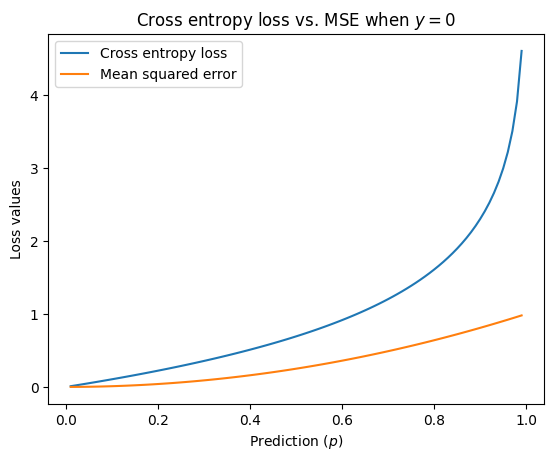

In [4]:
x = np.linspace(0.01, 0.99, 99)
y1 = -1.0 * np.log(1 - x)
y2 = (x - 0) ** 2
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(['Cross entropy loss', 'Mean squared error'])

plt.title("Cross entropy loss vs. MSE when $y = 0$")
plt.xlabel("Prediction ($p$)")
plt.ylabel("Loss values");
# plt.savefig(IMG_FILEPATH + "04_Log_loss_vs_MSE_y_eq_0.png")

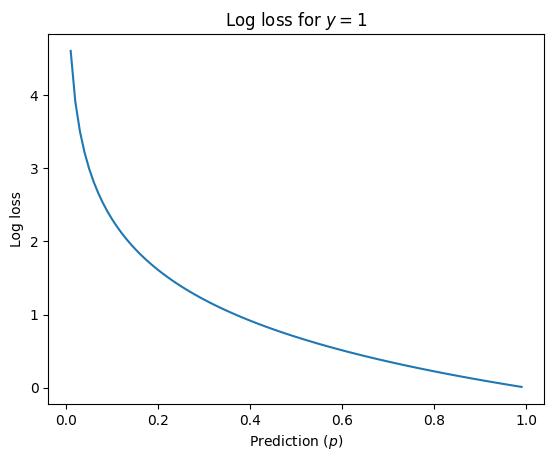

In [10]:
x = np.linspace(0.01, 0.99, 99)
y = -1.0 * np.log((x))

plt.plot(x, y)
plt.title("Log loss for $y = 1$")
plt.xlabel("Prediction ($p$)")
plt.ylabel("Log loss");

从上图可以看出，交叉熵的数值不仅要高，而且还陡峭。这意味着我们的模型会对错误的预测更加敏感，这有助于我们的模型更快地收敛到最小值。单我们将其与 `softmax` 结合时，真正的奇迹就出现了：首先通过 `softmax` 函数输入神经网络输出，使其归一化，从而使数值相加为 1，然后将得到的概率输入交叉熵损失函数。

我们给出当 `y` 等于 1 时的交叉熵函数：

$$
SCE_1 = -y_1 \times \log
\left(
\frac{e^{x_1}}{e^{x_1} + e^{x_2} + e^{x_3}}
\right) - (1-y_1) \times \log
\left(
1 - \frac{e^{x_1}}{e^{x_1} + e^{x_2} + e^{x_3}}
\right)
$$


对 $x_1$ 求导：

$$
\frac{\partial SCE_1}{\partial x_1} = \frac{e^{x_1}}{e^{x_1} + e^{x_2} + e^{x_3}} - y_1
$$


也就是：

$$
softmax\left(
\begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
\end{bmatrix}
\right) - 
\begin{bmatrix}
y_1 \\
y_2 \\
y_3 \\
\end{bmatrix}
$$

In [1]:
from .utils import unnormalize


class SoftmaxCrossEntropy(Loss):
    def __init__(self, eps: float = 1e-9) -> None:
        super().__init__()
        self.eps = eps
        self.single_class = False

    def _output(self) -> float:

        # if the network is just outputting probabilities
        # of just belonging to one class:
        if self.target.shape[1] == 0:
            self.single_class = True

        # if "single_class", apply the "normalize" operation defined above:
        if self.single_class:
            self.prediction, self.target = \
                normalize(self.prediction), normalize(self.target)

        # applying the softmax function to each row (observation)
        softmax_preds = softmax(self.prediction, axis=1)

        # clipping the softmax output to prevent numeric instability
        self.softmax_preds = np.clip(softmax_preds, self.eps, 1 - self.eps)

        # actual loss computation
        softmax_cross_entropy_loss = (
                -1.0 * self.target * np.log(self.softmax_preds) - \
                (1.0 - self.target) * np.log(1 - self.softmax_preds)
        )

        return np.sum(softmax_cross_entropy_loss) / self.prediction.shape[0]

    def _input_grad(self) -> np.ndarray:

        # if "single_class", "un-normalize" probabilities before returning gradient:
        if self.single_class:
            return unnormalize(self.softmax_preds - self.target)
        else:
            return (self.softmax_preds - self.target) / self.prediction.shape[0]

ImportError: attempted relative import with no known parent package

### 其他激活函数

#### RLU：Rectified Linear Unit

缺点与 `sigmoid` 刚好相反，当 `x` 小于 0 时，梯度为 0。

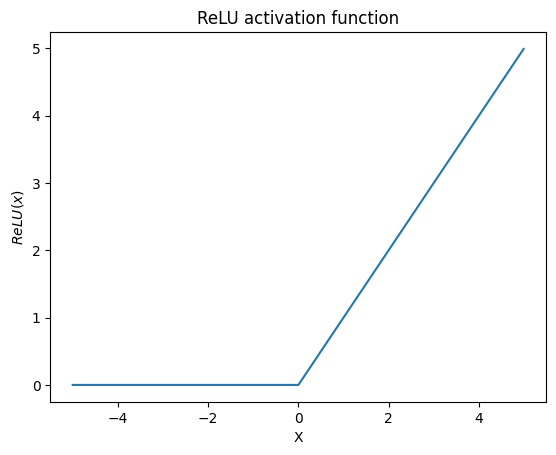

In [4]:
def relu(x):
    return np.array([el if el > 0 else 0 for el in x])


a = np.arange(-5, 5, 0.01)
plt.plot(a, relu(a))
plt.title("ReLU activation function")
plt.xlabel("X")
plt.ylabel("$ReLU(x)$");
# plt.savefig(IMG_FILEPATH + "04_relu_activation.png")

#### Tanh

与 `sigmoid` 类似，但是输入范围是 [-1, 1]，`sigmoid` 的输入范围是 [0, 1]。

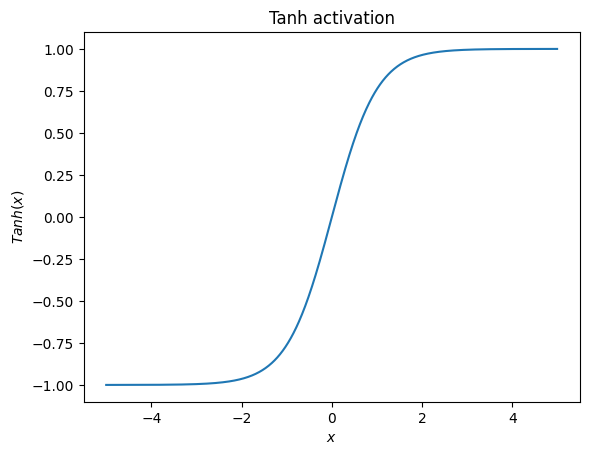

In [5]:
a = np.arange(-5, 5, 0.01)
plt.plot(a, np.tanh(a))
plt.title("Tanh activation")
plt.xlabel("$x$")
plt.ylabel("$Tanh(x)$");
# plt.savefig(IMG_FILEPATH + "05_tanh_activation.png")

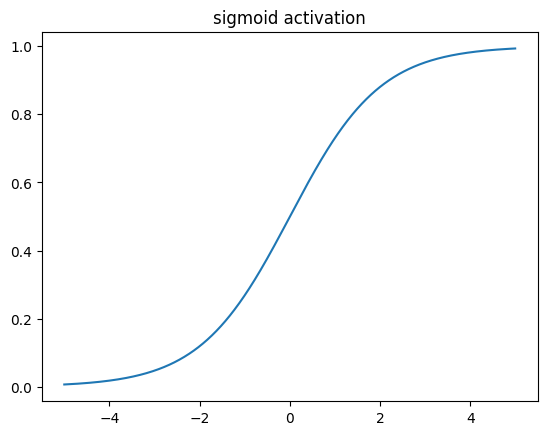

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


a = np.arange(-5, 5, 0.01)
plt.title("sigmoid activation")
plt.plot(a, sigmoid(a));

#### 导数

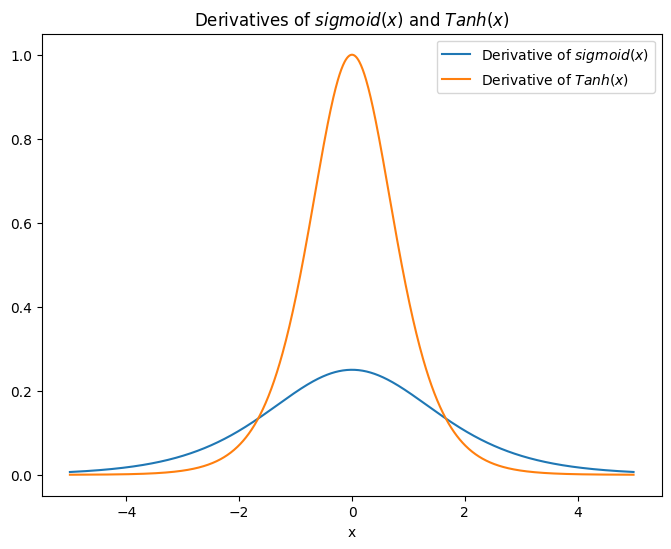

In [7]:
a = np.arange(-5, 5, 0.01)
plt.figure(figsize=(8, 6))
plt.plot(a, sigmoid(a) * (1 - (sigmoid(a))))
plt.plot(a, 1 - (np.tanh(a) ** 2))
plt.legend(['Derivative of $sigmoid(x)$',
            'Derivative of $Tanh(x)$'])
plt.title("Derivatives of $sigmoid(x)$ and $Tanh(x)$")
plt.xlabel("x");
# plt.savefig(IMG_FILEPATH + "06_sigmoid_tanh_derivative.png")

我们想要一个激活函数，它允许我们的网络学习输入和输出之间的非线性关系，同时不增加不必要的复杂性，以免网络更难找到好的解决方案。因此综合下来，我们在例子中选择 `Tanh` 作为激活函数。

### Experiments

使用 MNIST 数据集，我们将训练一个简单的神经网络，然后使用 `softmax` 交叉熵损失函数来训练它。

In [16]:
import os
import sys

cur_dir = os.getcwd()
pkg_rootdir = os.path.dirname(os.path.dirname(cur_dir))
# print(pkg_rootdir)
if pkg_rootdir not in sys.path:
    sys.path.append(pkg_rootdir)

In [18]:
from ml.dl.lincoln.layers import Dense
from ml.dl.lincoln.losses import SoftmaxCrossEntropy, MeanSquaredError
from ml.dl.lincoln.optimizers import Optimizer, SGD, SGDMomentum
from ml.dl.lincoln.activations import Sigmoid, Tanh, Linear, ReLU
from ml.dl.lincoln.network import NeuralNetwork
from ml.dl.lincoln.train import Trainer
from ml.dl.lincoln.utils import mnist
from ml.dl.lincoln.utils.np_utils import softmax


In [21]:
mnist.save_mnist()

FileNotFoundError: [Errno 2] No such file or directory: 'train-images-idx3-ubyte.gz'

In [19]:
X_train, y_train, X_test, y_test = mnist.load()

FileNotFoundError: [Errno 2] No such file or directory: 'mnist.pkl'

## Momentum

在目前中，每个时间步（time step）中只用了一种 "更新规则"用于更新我们的权重，也就是求损失相对于权重的导数，让将权重移动到最终的正确方向。让我们先来了解一下为什么我们要将这一更新规则扩展到包含动量（momentum）。


### Intuition

在之前的例子中，由于每次迭代时损失都在持续减少，因此参数值会朝着同一方向持续更新。这就好比参数 "rolling down a hill"，而每个时间步的更新值就好比参数的 "速度"(velocity)。
在现实世界中，物体不会瞬间停止并改变方向；这是因为它们有动量，这只是一种简洁的说法，即它们在某一时刻的速度不仅是该时刻作用在它们身上的力的函数，也是它们过去累积速度的函数，而过去的速度所占的权重更大。


我们可以将上述机制应用到权重更新中。

基于动量的权重更新意味着每个时间步的参数更新将是过去时间步的参数更新的加权平均值，权重呈指数衰减，因此需要第二个参数 `gamma` 来控制这种衰减，参数值越高，每个时间步长的权重更新就越多地基于参数的累积动量，而不是其当前速度。


### Math

从数学角度来看，假设动量参数为 $\mu$ ，每个时间步的梯度为 $\nabla_t$ 我们可以将动量更新规则表示为：

$$
update = \nabla_t + \mu \times \nabla_{t-1} + \mu^2 \times \nabla_{t-2} + \ldots
$$

使用 `SGDMomentum` 可以加速我们得训练过程，除了每次迭代时修改参数更新之外，另外一种方法就是修改学习率。学习率除了可以手动指定外，还可以使用某种规则随着训练的进行而自动衰减学习率。我们将在下一节中讨论这个问题。

## Learning Rate Decay

在前面我们看到，如果一直保持一个较大的学习率，那么我们的模型可能会在最小值附近来回震荡，而如果学习率太小，我们的模型可能会陷入局部最小值。因此，我们需要一种方法来动态调整学习率，使其随着训练的进行而逐渐减小。学习率衰减可以让我们对这一过程进行更精细的控制。

### Types of Learning Rate Decay

- 线性衰减（linear decay）

- 指数衰减（exponential decay）

## Weight Initialization

## Dropout